# Does having an unlimited dimension affect NetCDF throughput?

tl;dr Not much. See below for details.

In [1]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect

sys.path.append('../util')
from meters import ThroughputMeter
import ncgen

import netCDF4
import numpy as np
import pylab as pl

os.environ['TMPDIR'] = os.getenv('HOME') + '/tmp/'

In [2]:
results = []
for unlim in [True, False]:
    for num_vars in range(1, 20, 2):
        print("Creating a NetCDF file with {} {}limited variables".format(num_vars, 'un' if unlim else ''))
        with NamedTemporaryFile(suffix='.nc', delete=False) as f:
            nc = ncgen.make_multivariable_nc(f.name, num_vars=num_vars, unlim=unlim)
            nc.close()
        nc = netCDF4.Dataset(f.name, 'r')
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][:, :, :]
        
        # python-netCDF4 seems to leak file descriptors
        # We have to take a lot of steps to make sure that the files get closed and that
        # the space gets reclaimed by the OS
        nc.close
        del nc
        print("Removing {}".format(f.name))
        os.remove(f.name)
        f.close()
        collect()
        results.append((unlim, num_vars, t.megabytes_per_second(a)))


Creating a NetCDF file with 1 unlimited variables
Removing /home/james/tmp/tmpcn634v.nc
353.100 MB in 0.554 seconds at 637.627 MB / sec
Creating a NetCDF file with 3 unlimited variables
Removing /home/james/tmp/tmp20uegw.nc
353.100 MB in 0.528 seconds at 668.801 MB / sec
Creating a NetCDF file with 5 unlimited variables
Removing /home/james/tmp/tmp3dxm8d.nc
353.100 MB in 0.526 seconds at 671.225 MB / sec
Creating a NetCDF file with 7 unlimited variables
Removing /home/james/tmp/tmptcw6lh.nc
353.100 MB in 0.537 seconds at 657.472 MB / sec
Creating a NetCDF file with 9 unlimited variables
Removing /home/james/tmp/tmpwrcdz_.nc
353.100 MB in 0.53 seconds at 666.329 MB / sec
Creating a NetCDF file with 11 unlimited variables
Removing /home/james/tmp/tmptoknkx.nc
353.100 MB in 3.76 seconds at 93.943 MB / sec
Creating a NetCDF file with 13 unlimited variables
Removing /home/james/tmp/tmplfe7j1.nc
353.100 MB in 3.71 seconds at 95.182 MB / sec
Creating a NetCDF file with 15 unlimited variables


In [3]:
results

[(True, 1, 637.62729771794284),
 (True, 3, 668.80147397512667),
 (True, 5, 671.22488187905776),
 (True, 7, 657.47217632419392),
 (True, 9, 666.32924149523353),
 (True, 11, 93.9431909761702),
 (True, 13, 95.181981452780875),
 (True, 15, 93.305978835965504),
 (True, 17, 94.957399860033107),
 (True, 19, 97.657836468314542),
 (False, 1, 736.86027437336088),
 (False, 3, 748.60546261919626),
 (False, 5, 747.88757401828252),
 (False, 7, 753.57442846166759),
 (False, 9, 582.0785012083669),
 (False, 11, 754.38819472389321),
 (False, 13, 96.139948949356565),
 (False, 15, 97.605504369488713),
 (False, 17, 98.696470675731589),
 (False, 19, 59.692869018897959)]

In [4]:
a = np.array([result[2] for result in results])

In [5]:
a = a.reshape((2, 10))

In [6]:
%matplotlib inline

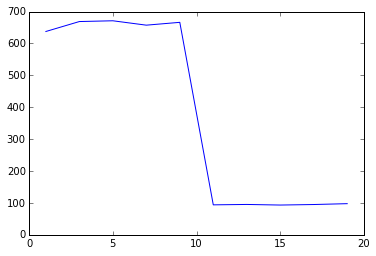

In [12]:
pl.plot(range(1, 20, 2), a[0,:])

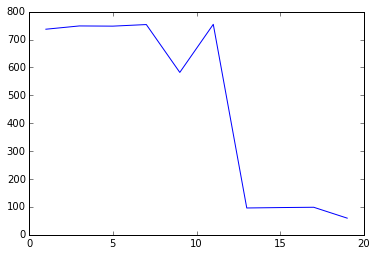

In [13]:
pl.plot(range(1, 20, 2), a[1,:])

There seems to be some threshold at 9+ variables. Maybe that's the size at which it cannot be cached in memory?

In [15]:
353.100 * np.arange(9, 15)

array([ 3177.9,  3531. ,  3884.1,  4237.2,  4590.3,  4943.4])

In [10]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7945       2724       5221        377          2        457
-/+ buffers/cache:       2263       5681
Swap:        47685        159      47525


On this run I had about 5700 MB free on the system, so it's plausible that 9+ variables at 3000+ MB pushes me out of cache on to disk. That explains the jump. But, the morale of the story here is that there is not much distinguishable difference between the throughput of unlimited and limited variables. At least at such low number of time steps. Maybe we should run this experiment again with annual or monthly data.

In [11]:
!hostname

basalt
